In [0]:
d=[]
while(1):
  d.append('1')

In [0]:
import os
import math
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import shutil

from datetime import datetime
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score

In [0]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
    torch.device('cuda')

In [0]:
# constants
EMBED_DIM = 300
BATCH_SIZE = 16
EPOCHS = 50
PAD_WORD = '`'
PAD_TAG = -1

# Loading

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# path to the embeddings file
embed_path = '/content/drive/My Drive/cc.ru.300.bin'

In [0]:
!pip install fasttext

import fasttext.util
import fasttext

ft = fasttext.load_model(embed_path)

     |████████████████████████████████| 61kB 2.2MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.1-cp36-cp36m-linux_x86_64.whl size=2385479 sha256=281890c3d480222603ad5f9c2f18a652fc096d07cb46462f0665225ab51b9a8e
  Stored in directory: /root/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext


# Model

In [0]:
class Event_tagger(nn.Module):
    def __init__(self,
                 word_to_ix,
                 tag_to_ix,
                 ix_to_tag,
                 weights_matrix,
                 batch_size,
                 word_embed_dim=300,
                 lstm_num_layers=2,
                 bidirectional=True,
                 dropout=.5):
        '''
            initialize models
            batch_size      - size of batches for traininig
            word_embed_dim  - dimension of word embeddings
            lstm_num_layers - number of LSTM layers
            dropout         - rate for dropout layer
        '''
        super(Event_tagger, self).__init__()

        # dictionaries
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        self.ix_to_tag = ix_to_tag

        # parameters
        self.batch_size = batch_size
        self.word_embed_dim = word_embed_dim
        self.lstm_hidden_dim = self.word_embed_dim
        self.lstm_num_layers = lstm_num_layers
        self.dropout = dropout

        self.num_directions = 2 if bidirectional else 1

        self.word_embeds, num_embeds = create_embed_layer(weights_matrix, True)
        self.lstm_hidden_embeds = self.init_hidden_embeddings(self.batch_size)

        self.lstm = nn.LSTM(self.word_embed_dim,
                            self.lstm_hidden_dim,
                            dropout=self.dropout,
                            num_layers=self.lstm_num_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.dense = nn.Linear(self.lstm_hidden_dim * self.num_directions,
                               len(self.tag_to_ix))

    def init_hidden_embeddings(self, batch_size):
        '''
            initialize hidden embeddings as zeros
        '''
        return (torch.zeros(self.lstm_num_layers * self.num_directions,
                            batch_size, self.lstm_hidden_dim),
                torch.zeros(self.lstm_num_layers * self.num_directions,
                            batch_size, self.lstm_hidden_dim))
        
    def forward(self, words_batch):
        '''
            words_batch - contains indices of words in current batch with shape
                        (batch_size, num_words_in_sentence)

            creates word level word embeddings from words_batch

            runs Bi-directional LSTM over input word representation to get
            final word representation which is fed to linear layer and softmax
            activation function to generate probability distribution for event
            tag set
        '''
        # create word-level word embeddings
        word_embed_word_level = words_batch.view(-1)
        word_embed_word_level = self.word_embeds(word_embed_word_level)
        batch_sent_embed = word_embed_word_level.view(words_batch.shape[0], -1,
                                                 word_embed_word_level.shape[-1])

        # create final word representation from LSTM
        lstm_out, self.lstm_hidden_embeds = self.lstm(batch_sent_embed,
                                                      self.lstm_hidden_embeds)

        # get probabilities for event tag
        tag_space = self.dense(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=2)
        return tag_space

In [0]:
class Corpus(Dataset):
    def __init__(self, word_to_ix, tag_to_ix, data):
        self.word_to_ix = word_to_ix
        self.tag_to_ix = tag_to_ix
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence, tags = self.data[idx]
        return ' '.join(sentence), ' '.join(tags)

In [0]:
def save_model(state, is_best, checkpoint_dir, best_model_dir):
    f_path = 'models/' + checkpoint_dir + '_model.pt'
    if not os.path.exists('models'):
        os.makedirs('models')

    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_dir + '/best_model.pt'
        if not os.path.exists(best_model_dir):
            os.makedirs(best_model_dir)

        shutil.copyfile(f_path, best_fpath)


def load_model(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [0]:
def create_embed_layer(weights_matrix, non_trainable=False):
    '''
        custom embedding layer
    '''
    num_embeds, embed_dim = weights_matrix.size()
    embed_layer = nn.Embedding(num_embeds, embed_dim)
    embed_layer.load_state_dict({'weight': weights_matrix})
    if non_trainable:
        embed_layer.weight.requires_grad = False

    return embed_layer, num_embeds

# Prepare dictionaries

In [0]:
def create_vocabulary(df):
    '''
        creates vocabulary from dataset
    '''
    all_words = list(set(list(df.word)))
    word_to_ix = {all_words[ix]:ix for ix in range(len(all_words))}

    all_tags = list(set(list(df.type)))
    tag_to_ix = {all_tags[ix]:ix for ix in range(len(all_tags))}
    ix_to_tag = dict([(value, key) for key, value in tag_to_ix.items()])

    word_to_ix[PAD_WORD] = len(word_to_ix)
    data = create_data(df)

    return word_to_ix, (tag_to_ix, ix_to_tag), data

In [0]:
def create_data(df):
    sentences = []

    doc_ids = list(set(df.doc))
    for doc_id in doc_ids:
        sent_ids = list(set(df[df.doc == doc_id].sentence))
        df_docs = df[df.doc == doc_id]
        for sent_id in sent_ids:
            df_sents = df_docs[df_docs.sentence == sent_id]

            words = [word for word in df_sents.word]
            tags = [tag for tag in df_sents.type]

            sentences.append((words, tags))
    return sentences

In [0]:
def create_embed_weights(target_vocab, ft):
    '''
        For each word in dataset’s vocabulary, we check if it is vocabulary.
        If it is, we load its pre-trained word vector.
        Otherwise, we initialize a random vector.
    '''
    matrix_len = len(target_vocab)
    weights_matrix = np.zeros((matrix_len, EMBED_DIM))
    words_found = 0

    for word, ix in target_vocab.items():
        try:
            weights_matrix[ix] = ft.get_word_vector(word)
            words_found += 1
        except KeyError:
            weights_matrix[ix] = np.random.normal(scale=0.6, size=(EMBED_DIM, ))

    return torch.as_tensor(weights_matrix)

# Test

In [0]:
def sentences_to_indices(sentences, word_to_ix, tag_to_ix):
    '''
        sentences - [[token, ...], [token, ...], ...]
        converts sentences to word indices
    '''
    all_word_indices = []
    all_target_indices = []
    for sent in sentences:
        word_indices, target_indices = get_indices_train(sent, word_to_ix, tag_to_ix)
        all_word_indices.append(word_indices)
        all_target_indices.append(target_indices)
    return all_word_indices, all_target_indices

In [0]:
def get_indices_train(sentence, word_to_ix, tag_to_ix):
    '''
        retrieves indices of sentence from helpping dictionaries,
        maximum length of word in sentence
    '''
    word_indices = []
    target_indices = []
    for token in range(len(sentence[0])):
        # read word index from dictionary
        # if word is not in the dictionary treat as unknown word
        tok = sentence[0][token] if sentence[0][token] in word_to_ix else PAD_WORD
        tag = sentence[1][token] if sentence[1][token] in tag_to_ix else PAD_TAG
        word_indices.append(word_to_ix[tok])
        target_indices.append(tag_to_ix[tag])

    return torch.tensor(word_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

In [0]:
def test_train_split(df, ratio=.2):
    max_doc = df.iloc[-1].doc
    # :ratio: - percentage of data left to testing
    split_doc = max_doc * (1 - ratio)

    df_train = df[df.doc <= split_doc]
    df_test = df[df.doc > split_doc]

    return df_train, df_test

In [0]:
def test_sentences(df):
    # load model
    model_path = '/content/drive/My Drive/model-3.pt'
    model = torch.load(model_path)

    batch_size = 1

    model.lstm_hidden_embeds = model.init_hidden_embeddings(batch_size)
    model.lstm.flatten_parameters()

    word_to_ix = model.word_to_ix
    ix_to_tag = model.ix_to_tag
    tag_to_ix = model.tag_to_ix
    tag_to_ix[-1] = len(tag_to_ix)
    # print(tag_to_ix['-1'])

    # load test dataset
    data = create_data(df)
    print(data[0])

    predicted_tags = []
    y_true = []

    word_indices, target_indices = sentences_to_indices(data, word_to_ix, tag_to_ix)
    # run test dataset through model 
    for i in range(len(word_indices)):
        tag_scores = model(torch.stack([word_indices[i]]))
        out_probs = torch.squeeze(tag_scores)
        tmp = []
        for j, pset in enumerate(out_probs):
            if j >= len(word_indices[i]):
                break
            _, predicted_ix = torch.max(pset, 0)
            predicted_tags.append(predicted_ix.item())
            tmp.append(predicted_ix.item())
        y_true.extend(target_indices[i])
    return predicted_tags, y_true

In [0]:
df = pd.read_csv('/content/drive/My Drive/output.csv')

In [0]:
df_train, df_test = test_train_split(df)
# word_to_ix, tag_dicts, data = create_vocabulary(df_train)

In [20]:
predicted_tags, y_true = test_sentences(df_test)

(['Автобус', 'столкнулся', 'с', '"', 'Газелью', '"', 'под', 'Уфой', ':', '10', 'пострадавших', 'УФА', ',', '2', 'июля', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-T-GPE-Location', 'O', 'B-T-Person', 'I-T-Person', 'B-T-GPE-Location', 'O', 'B-T-Time', 'I-T-Time', 'O'])


In [0]:
import pickle

with open('predicted.pickle', 'wb') as f:
    pickle.dump(predicted_tags, f)

with open('y_true.pickle', 'wb') as f:
    pickle.dump(y_true, f)

In [0]:
model_path = '/content/drive/My Drive/model-3.pt'
model = torch.load(model_path)

# Eval

In [23]:
print('F1 score {:.3f}'.format(f1_score(y_true, predicted_tags, average='weighted')))

F1 score 0.833


In [24]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sn

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from collections import Counter

In [26]:
len(model.tag_to_ix)

53

In [0]:
ix_to_tag = model.ix_to_tag

In [0]:
y_true_list = [float(y) for y in y_true]
count_classes_occurences = dict(Counter(y_true_list))

In [30]:
for ix in count_classes_occurences:
    if ix == 53:
        continue
        
    print('Tag {} has {} of {} occurences'.format(ix_to_tag[ix],
                                                  count_classes_occurences[ix],
                                                  len(y_true)))
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(y_true_list)):
        if y_true_list[i] == ix and predicted_tags[i] == ix:
            tp += 1
        elif y_true_list[i] != ix and predicted_tags[i] != ix:
            tn += 1
        elif y_true_list[i] == ix and predicted_tags[i] != ix:
            fp += 1
        elif y_true_list[i] != ix and predicted_tags[i] == ix:
            fn += 1

    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    selectivity = tn / (tn + fp) if (tn + fp) != 0 else 0

    balanced_acc = (recall + selectivity) / 2
    f_measure = precision * recall / (precision + recall) if (precision + recall) != 0 else 0
    print('precision {:.3f} | recall {:.3f} | selectivity {:.3f} | balanced accuracy {:.3f} | f measure {:.3f}'.format(precision, recall,
                                                           selectivity, 
                                                           balanced_acc,
                                                            f_measure))

Tag O has 43406 of 67087 occurences
precision 0.935 | recall 0.908 | selectivity 0.873 | balanced accuracy 0.891 | f measure 0.461
Tag B-T-GPE-Location has 669 of 67087 occurences
precision 0.659 | recall 0.646 | selectivity 0.997 | balanced accuracy 0.821 | f measure 0.326
Tag B-T-Person has 3494 of 67087 occurences
precision 0.694 | recall 0.713 | selectivity 0.983 | balanced accuracy 0.848 | f measure 0.352
Tag I-T-Person has 4295 of 67087 occurences
precision 0.679 | recall 0.828 | selectivity 0.978 | balanced accuracy 0.903 | f measure 0.373
Tag B-T-Time has 1156 of 67087 occurences
precision 0.773 | recall 0.804 | selectivity 0.996 | balanced accuracy 0.900 | f measure 0.394
Tag I-T-Time has 2322 of 67087 occurences
precision 0.872 | recall 0.876 | selectivity 0.995 | balanced accuracy 0.936 | f measure 0.437
Tag B-E-Injure has 97 of 67087 occurences
precision 0.062 | recall 0.545 | selectivity 0.999 | balanced accuracy 0.772 | f measure 0.056
Tag B-T-Organization has 2536 of 670

In [0]:
confusion_matrix = multilabel_confusion_matrix(y_true, predicted_tags)

I-T-GPE-Person


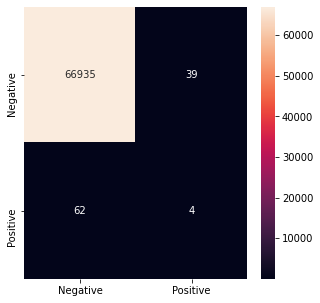

I-T-GPE-GPE


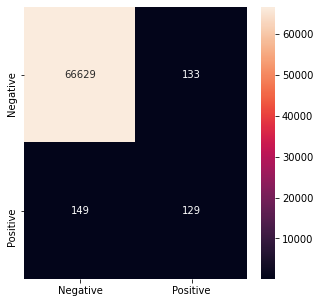

I-T-E-Mail


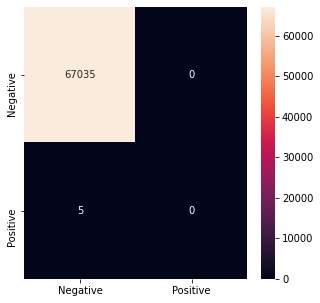

I-E-Fine


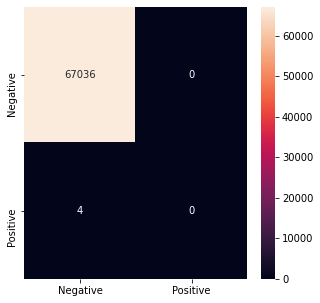

I-E-Transfer-Money


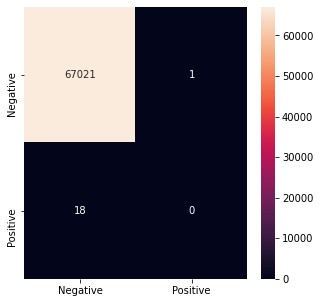

I-E-Injure


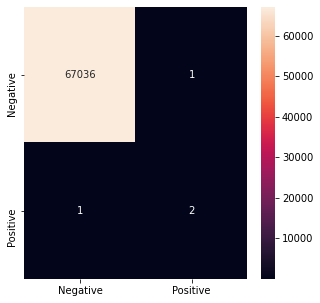

B-E-End-Org


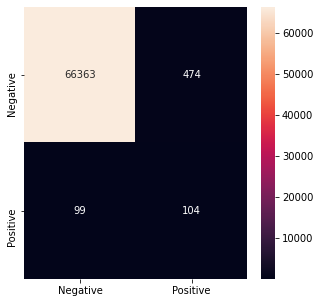

B-T-Phone-Number


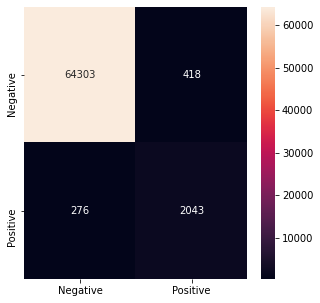

I-T-Location


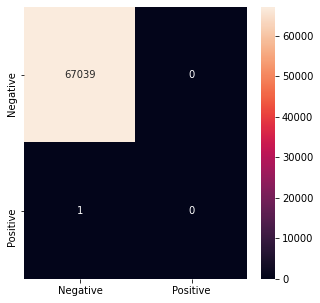

I-T-Time


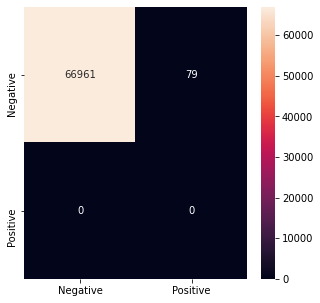

I-E-Sentence


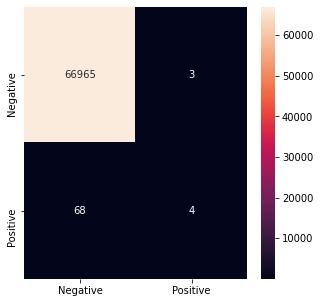

I-T-Job


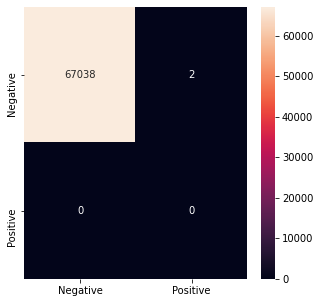

B-T-GPE-Person


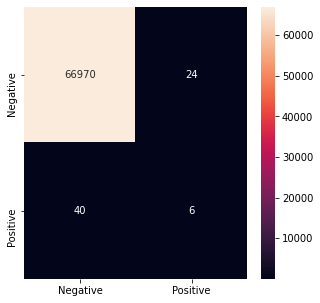

B-T-Crime


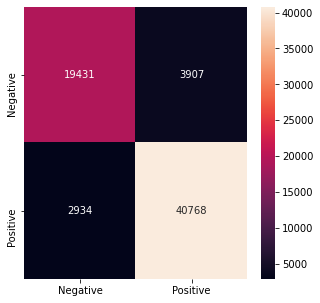

I-T-URL


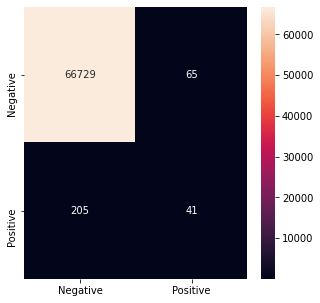

O


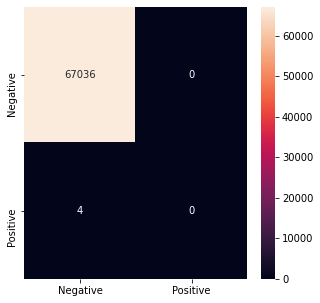

B-T-GPE-Organization


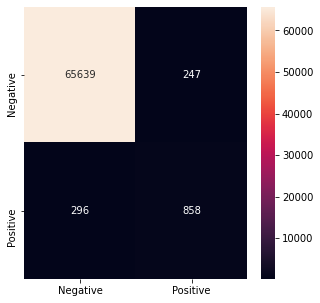

B-E-Merge-Org


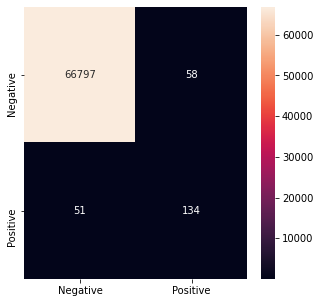

B-T-Time


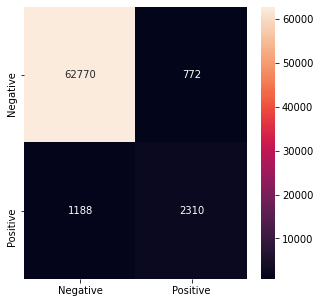

B-T-Money


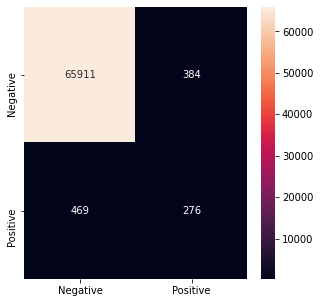

B-T-Person


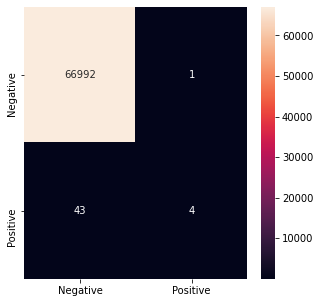

I-T-Facility


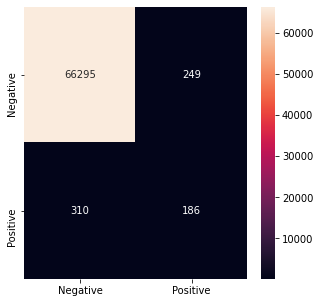

B-E-Start-Position


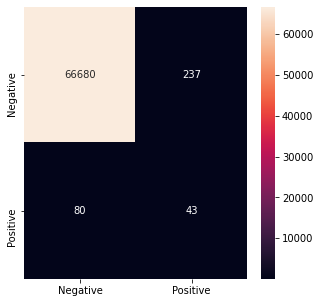

B-T-Facility


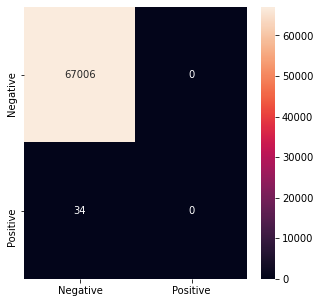

B-T-Location


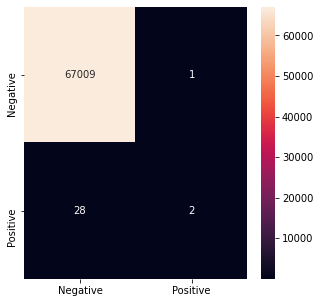

B-E-End-Position


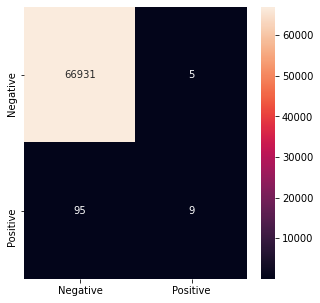

B-E-Trial-Hearing


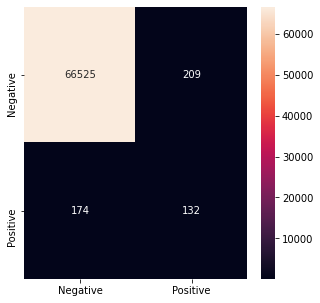

B-E-Injure


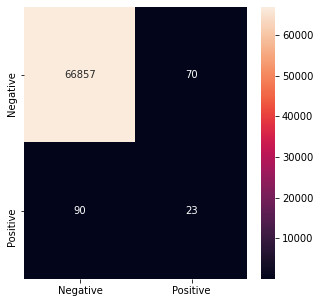

I-T-GPE-Location


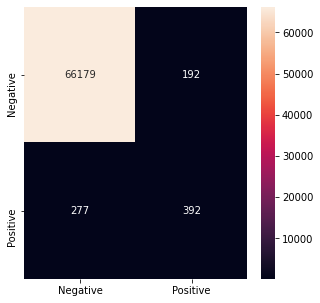

I-E-Trial-Hearing


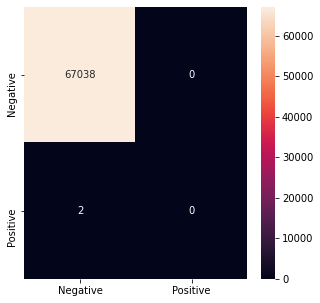

B-T-E-Mail


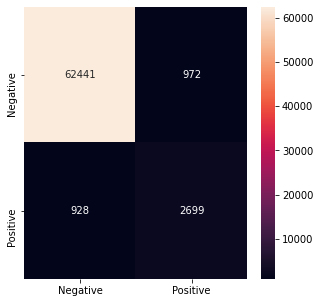

I-T-GPE-Organization


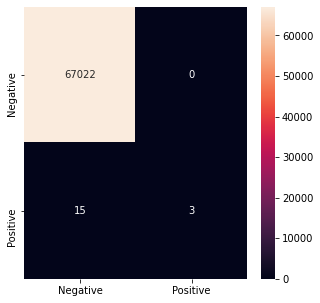

B-T-GPE-Location


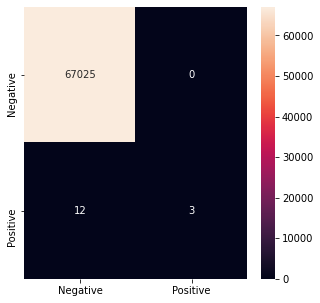

I-E-Indict-Sue


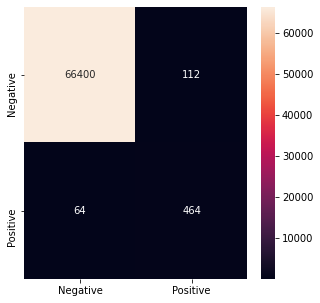

I-T-Organization


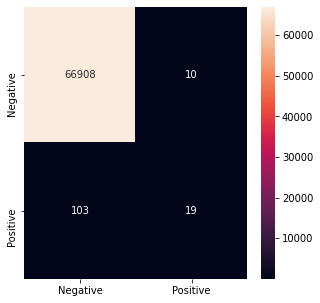

B-E-Fine


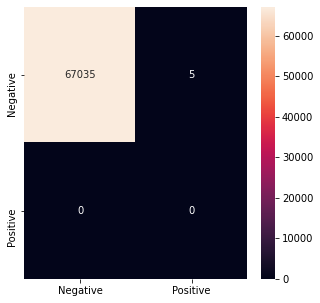

I-T-Phone-Number


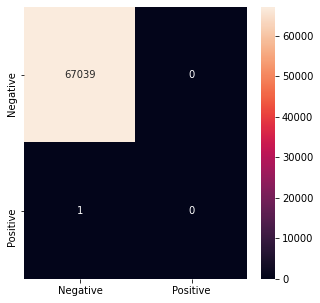

I-T-Money


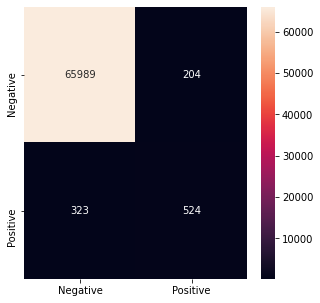

B-E-Indict-Sue


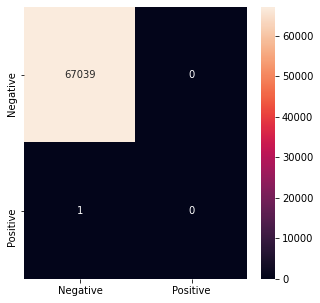

B-T-Job


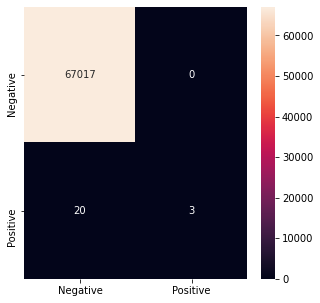

B-E-Declare-Bankruptcy


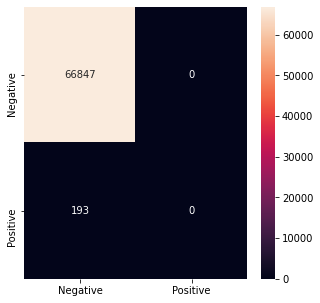

B-T-GPE-GPE


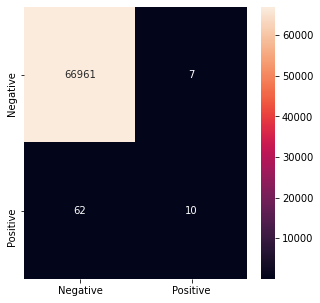

I-E-Die


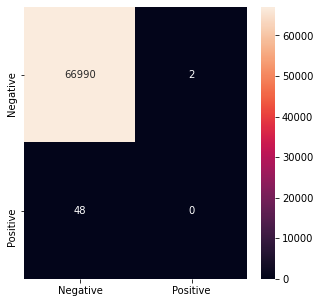

B-E-Start-Org


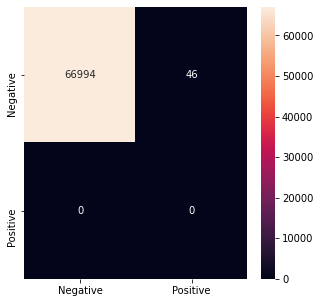

B-E-Transfer-Money


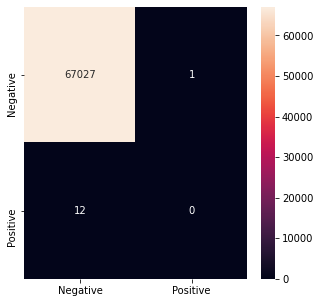

B-E-Sentence


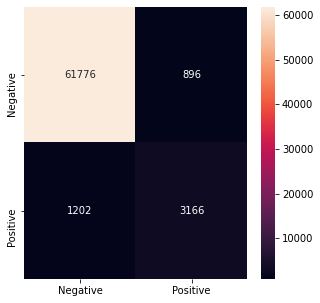

B-E-Transfer-Ownership


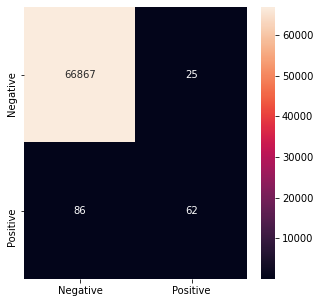

I-T-Crime


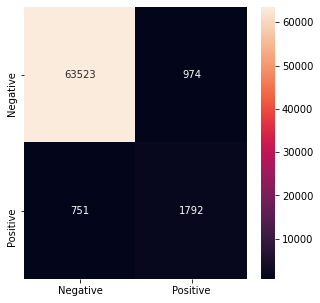

B-T-URL


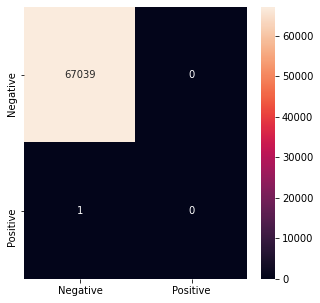

In [0]:
for i, con_mat in enumerate(confusion_matrix):
    print(model.ix_to_tag[i])
    df_cm = pd.DataFrame(con_mat, index = [i for i in ['Negative', 'Positive']],
                    columns = ['Negative', 'Positive'])
    plt.figure(figsize = (5, 5))
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.show()